## Transfer Learning and Drop-out

Transfer Learning for image classification for CNN and imagegenerator

Courser Google Colab: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/Course%202%20-%20Part%206%20-%20Lesson%203%20-%20Notebook.ipynb

Inception v3: https://arxiv.org/abs/1512.00567

keras tutorial on transfer learning: https://www.tensorflow.org/tutorials/images/transfer_learning

Inception v3 dataset: http://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels

Droput: https://www.youtube.com/watch?v=ARq74QuavAo

In [1]:
import os

%tensorflow_version 2.x
from tensorflow.keras import layers
from tensorflow.keras import Model

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'  # snapshot of the model weights

img_size = 150
pre_trained_model = InceptionV3(input_shape = (img_size, img_size, 3),  # desired image size
                                include_top = False,   # By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
                                weights = None)  # we don't want to use the built-in weights (hence weights=none) available in keras but we want to use the weights we have downloaded above in local_weights_file.

# we get the weights from the downloaded snapshot above (local_weights_file)
pre_trained_model.load_weights(local_weights_file)

# Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training
for layer in pre_trained_model.layers:
  layer.trainable = False
# pre_trained_model.trainable = False  # should do the same

  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

TensorFlow 2.x selected.
--2020-03-21 00:10:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 2607:f8b0:4004:806::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  59.9MB/s    in 1.4s    

2020-03-21 00:10:05 (59.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [0]:
# pre_trained_model_short=[]
# for layer in pre_trained_model.layers : 
#   if pre_trained_model.get_layer('mixed7') :
#     break
#   else :  
#     pre_trained_model_short.add(layer)

# pre_trained_model_short.summary()

idx = 0
for layer in pre_trained_model.layers : 
  if layer.name =='mixed7' :
    break
  else :  
    idx += 1

print(idx)

pre_trained_model_short = pre_trained_model.layers[:idx]

# pre_trained_model_short.summary()

279


tf.keras.Model for chaining layers:
https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [2]:
# Building our own deep layers below the transfered layer:

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.optimizers import RMSprop

# Chain the layers into an object with training and inference features. 
# the second () it's actually to chain to the previous layers!

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( inputs=pre_trained_model.input, outputs=x) 


# model = tf.keras.models.Sequential([
#                                     pre_trained_model.layers[:idx],
#                                     tf.keras.layers.Flatten(), # (last_output),
#                                     tf.keras.layers.Dense(1024, activation='relu'),
#                                     tf.keras.layers.Dropout(0.2),
#                                     tf.keras.layers.Dense(1, activation='sigmoid')
#                                     ])

model.summary()


model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


2.1.0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________________

In [3]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

img_size = 150 

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (img_size, img_size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_size, img_size))

--2020-03-21 00:10:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 2607:f8b0:4004:806::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   193MB/s    in 0.3s    

2020-03-21 00:10:46 (193 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    target=0.95
    if (logs['accuracy']>target):
      print('Reached %0.1f%% training accuracty. Training converged!' %(target*100))
      self.model.stop_training=True

callback = myCallback()


history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=[callback],
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 27s 272ms/step - loss: 0.4883 - accuracy: 0.7715 - val_loss: 0.1507 - val_accuracy: 0.9550
Epoch 2/30
100/100 [==============================] - 18s 183ms/step - loss: 0.3613 - accuracy: 0.8395 - val_loss: 0.2616 - val_accuracy: 0.9360
Epoch 3/30
100/100 [==============================] - 18s 181ms/step - loss: 0.3271 - accuracy: 0.8610 - val_loss: 0.4985 - val_accuracy: 0.9110
Epoch 4/30
100/100 [==============================] - 18s 184ms/step - loss: 0.3212 - accuracy: 0.8620 - val_loss: 0.2106 - val_accuracy: 0.9600
Epoch 5/30
100/100 [==============================] - 19s 185ms/step - loss: 0.3078 - accuracy: 0.8585 - val_loss: 0.4677 - val_accuracy: 0.9320
Epoch 6/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2898 - accuracy: 0.8745 - v

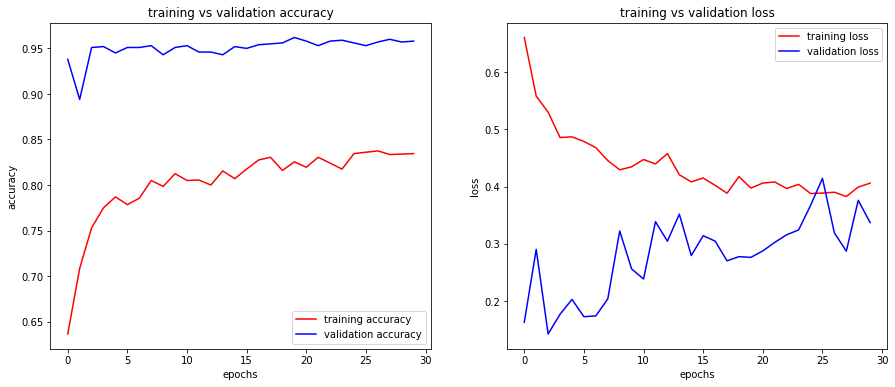

In [0]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(train_acc,'r',label='training accuracy')
plt.plot(val_acc,'b',label='validation accuracy')
plt.title('training vs validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss,'r',label='training loss')
plt.plot(val_loss,'b',label='validation loss')
plt.title('training vs validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

## Adding DROP-OUT:

In [0]:
# Building our own deep layers below the transfered layer:

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.optimizers import RMSprop

# Chain the layers into an object with training and inference features. 
# the second () it's actually to chain to the previous layers!

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( inputs=pre_trained_model.input, outputs=x) 


# model = tf.keras.models.Sequential([
#                                     pre_trained_model.layers[:idx],
#                                     tf.keras.layers.Flatten(), # (last_output),
#                                     tf.keras.layers.Dense(1024, activation='relu'),
#                                     tf.keras.layers.Dropout(0.2),
#                                     tf.keras.layers.Dense(1, activation='sigmoid')
#                                     ])

model.summary()


model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

1.15.0
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    target=0.95
    if (logs['accuracy']>target):
      print('Reached %0.1f%% training accuracty. Training converged!' %(target*100))
      self.model.stop_training=True

callback = myCallback()


history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=[callback],
    verbose=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 22s 218ms/step - loss: 0.4971 - accuracy: 0.7610 - val_loss: 0.1831 - val_accuracy: 0.9380
Epoch 2/30
100/100 [==============================] - 18s 184ms/step - loss: 0.3878 - accuracy: 0.8280 - val_loss: 0.1806 - val_accuracy: 0.9570
Epoch 3/30
100/100 [==============================] - 19s 185ms/step - loss: 0.3437 - accuracy: 0.8480 - val_loss: 0.2518 - val_accuracy: 0.9460
Epoch 4/30
100/100 [==============================] - 18s 185ms/step - loss: 0.3313 - accuracy: 0.8650 - val_loss: 0.4786 - val_accuracy: 0.9250
Epoch 5/30
100/100 [==============================] - 19s 190ms/step - loss: 0.3175 - accuracy: 0.8655 - val_loss: 0.3943 - val_accuracy: 0.9340
Epoch 6/30
100/100 [==============================] - 19s 185ms/step - loss: 0.3007 - accuracy: 0.8710 - val_loss: 0.5547 - val_accuracy: 0.9230
Epoch 7/30
100/100 [=================

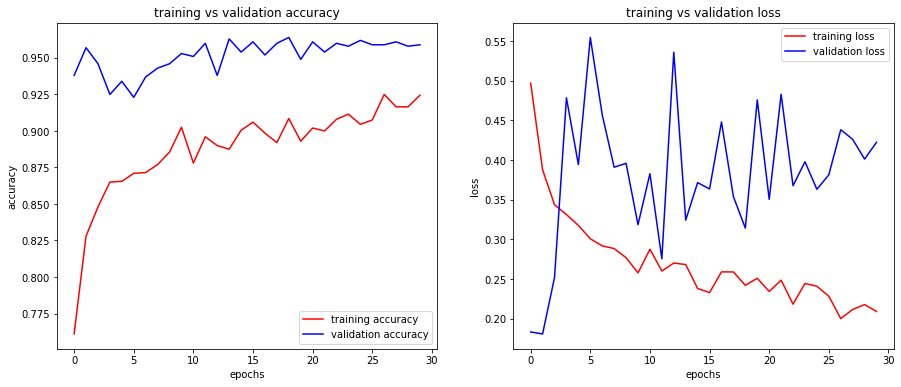

In [0]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(train_acc,'r',label='training accuracy')
plt.plot(val_acc,'b',label='validation accuracy')
plt.title('training vs validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss,'r',label='training loss')
plt.plot(val_loss,'b',label='validation loss')
plt.title('training vs validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

## Playing with my own options:

In [4]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  #  vertical_flip=True,
                                   fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

img_size = 150 

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (img_size, img_size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (img_size, img_size))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [7]:
# Building our own deep layers below the transfered layer:

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.optimizers import RMSprop

# Chain the layers into an object with training and inference features. 
# the second () it's actually to chain to the previous layers!

# Adding a Conv layer:
x = layers.Conv2D(64, (3, 3), activation='relu')(last_output)  # (x)
# Adding a MaxPooling layer:
# x = layers.MaxPool2D(2,2)(x)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)  # (last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)    
# # Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu')(x)
# # Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)                               
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( inputs=pre_trained_model.input, outputs=x) 


# model = tf.keras.models.Sequential([
#                                     pre_trained_model.layers[:idx],
#                                     tf.keras.layers.Flatten(), # (last_output),
#                                     tf.keras.layers.Dense(1024, activation='relu'),
#                                     tf.keras.layers.Dropout(0.2),
#                                     tf.keras.layers.Dense(1, activation='sigmoid')
#                                     ])

model.summary()


model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

2.1.0
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________

In [10]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    target=0.95
    if (logs['accuracy']>target):
      print('Reached %0.1f%% training accuracty. Training converged!' %(target*100))
      self.model.stop_training=True

callback = myCallback()


history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=[callback],
    verbose=1
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/40
100/100 [==============================] - 19s 190ms/step - loss: 0.1591 - accuracy: 0.9405 - val_loss: 0.6736 - val_accuracy: 0.9490
Epoch 2/40
100/100 [==============================] - 19s 187ms/step - loss: 0.1468 - accuracy: 0.9460 - val_loss: 0.7619 - val_accuracy: 0.9510
Epoch 3/40
100/100 [==============================] - 19s 188ms/step - loss: 0.1541 - accuracy: 0.9410 - val_loss: 0.8048 - val_accuracy: 0.9400
Epoch 4/40
100/100 [==============================] - 19s 189ms/step - loss: 0.1330 - accuracy: 0.9455 - val_loss: 0.6933 - val_accuracy: 0.9600
Epoch 5/40
100/100 [==============================] - 19s 192ms/step - loss: 0.1357 - accuracy: 0.9475 - val_loss: 0.9969 - val_accuracy: 0.9520
Epoch 6/40
100/100 [==============================] - 19s 185ms/step - loss: 0.1325 - accuracy: 0.9490 - val_loss: 0.9647 - val_accuracy: 0.9530
Epoch 7/40
100/100 [=================

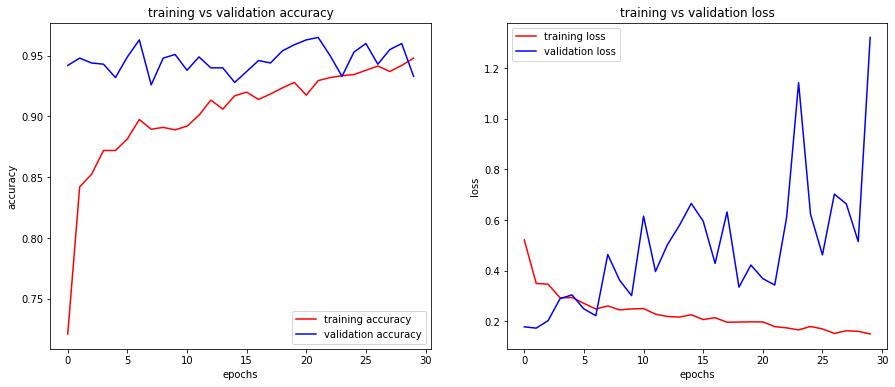

In [9]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(train_acc,'r',label='training accuracy')
plt.plot(val_acc,'b',label='validation accuracy')
plt.title('training vs validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss,'r',label='training loss')
plt.plot(val_loss,'b',label='validation loss')
plt.title('training vs validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()